In [1]:
from melee_dataset import MeleeDataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from torch.distributions import Categorical
from torch.distributions import Bernoulli,Normal
import matplotlib.pyplot as plt
from PolicyNet import PolicyNet
import torch.nn.functional as F
from Agents.BCAgent import BCAgent

%load_ext autoreload
%autoreload 2

In [2]:
# train_dataset = MeleeDataset(data_path="data/train_mini_515")
# train_dataset = MeleeDataset(data_path="data/train_mini_40")
train_dataset = MeleeDataset(data_path="data/train_mini_5")
# train_dataset = MeleeDataset(data_path="data/train_mini_10_with_hitstun")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = MeleeDataset(data_path="data/val_mini_1")
# val_dataset = MeleeDataset(data_path="data/val_mini_10")
# val_dataset = MeleeDataset(data_path="data/val_mini_2_with_hitstun")
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)


In [3]:
print(f"obs_dim: {train_dataset[0][0].shape}")
print(f"act_dim: {train_dataset[0][1].shape}")

obs_dim: torch.Size([70])
act_dim: torch.Size([17])


In [14]:

from Agents.BCAgent import BCAgent
from Agents.IQLAgent import IQLAgent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
obs_dim = train_dataset[0][0].shape[0]
act_dim = train_dataset[0][1].shape[0]
agent = BCAgent(obs_dim, act_dim, device)
# agent = IQLAgent(obs_dim, act_dim, device, param_update_freq=50)

# set the seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

losses = []
val_losses = []
batch_cnt = 0
for epoch in range(5):
    total_loss = 0.0
    for i, (states, actions, next_states) in tqdm(enumerate(train_loader)):
        states = states.to(device)       # [B, obs_dim]
        actions = actions.to(device)     # [B] integers in [0…act_dim-1]
        next_states = next_states.to(device)
        # for i in range(1000):
        loss = agent.train(states, actions, next_states)
        # vl, ql, pl = loss
        # print(loss)
        losses.append(loss)
        # break
        total_loss += loss * states.shape[0]
        batch_cnt += 1

        if batch_cnt % 100 == 0:
            val_loss = 0.0  
            for i, (states, actions, next_states) in tqdm(enumerate(val_loader)):
                states = states.to(device)       # [B, obs_dim]
                actions = actions.to(device)     # [B] integers in [0…act_dim-1]
                next_states = next_states.to(device)

                val_loss += agent.validate(states, actions)
            avg_val_loss = val_loss / len(val_dataset)
            val_losses.append(avg_val_loss)
            print(f"Epoch {epoch+1} — Val Loss: {avg_val_loss:.4f}")
    # break

    avg_loss = total_loss / len(train_dataset)
    # losses.append(avg_loss)
    print(f"Epoch {epoch+1} — Loss: {avg_loss:.4f}")




Using device: cuda


73it [00:00, 941.42it/s]
133it [00:00, 266.32it/s]

Epoch 1 — Val Loss: -9.6461


73it [00:00, 871.96it/s]]
252it [00:00, 245.62it/s]

Epoch 1 — Val Loss: -12.6800


73it [00:00, 972.97it/s]]
355it [00:01, 257.18it/s]


Epoch 1 — Val Loss: -15.0066
Epoch 1 — Loss: -11.5284


73it [00:00, 944.28it/s]
91it [00:00, 241.91it/s]

Epoch 2 — Val Loss: -16.6722


73it [00:00, 943.42it/s]]
183it [00:00, 250.55it/s]

Epoch 2 — Val Loss: -17.2405


73it [00:00, 919.76it/s]]
276it [00:01, 246.24it/s]

Epoch 2 — Val Loss: -18.5236


73it [00:00, 962.11it/s]]
355it [00:01, 242.37it/s]


Epoch 2 — Val Loss: -18.6365
Epoch 2 — Loss: -18.3036


73it [00:00, 963.85it/s]
126it [00:00, 261.11it/s]

Epoch 3 — Val Loss: -18.8049


73it [00:00, 912.43it/s]]
222it [00:00, 254.80it/s]

Epoch 3 — Val Loss: -18.6722


73it [00:00, 961.60it/s]]
355it [00:01, 261.94it/s]


Epoch 3 — Val Loss: -19.4255
Epoch 3 — Loss: -20.3600


73it [00:00, 944.85it/s]
108it [00:00, 301.62it/s]

Epoch 4 — Val Loss: -19.2211


73it [00:00, 971.59it/s]
181it [00:00, 298.39it/s]

Epoch 4 — Val Loss: -19.0914


73it [00:00, 987.10it/s]]
297it [00:00, 311.78it/s]

Epoch 4 — Val Loss: -19.3179


73it [00:00, 969.32it/s]]
355it [00:01, 286.29it/s]


Epoch 4 — Val Loss: -19.2506
Epoch 4 — Loss: -21.2508


73it [00:00, 972.75it/s]
132it [00:00, 270.63it/s]

Epoch 5 — Val Loss: -19.0136


73it [00:00, 995.36it/s]]
229it [00:00, 266.75it/s]

Epoch 5 — Val Loss: -19.3623


73it [00:00, 964.05it/s]]
355it [00:01, 274.21it/s]

Epoch 5 — Val Loss: -19.5021
Epoch 5 — Loss: -21.8659


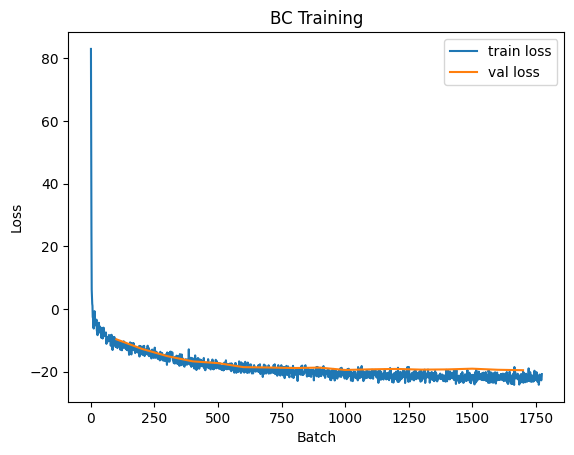

In [19]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.title("BC Training")
plt.xlabel("Batch")
plt.ylabel("Loss")
# plt.xticks(np.arange(0, 6, 1))
# plt.yscale("log")
# plt.plot([losses[i][0] for i in range(len(losses))], label="vl")
# plt.plot([losses[i][1] for i in range(len(losses))], label="ql")
# plt.plot([losses[i][2] for i in range(len(losses))], label="pl")
plt.plot(losses, label="train loss")
plt.plot([100 * i for i in range(1, len(val_losses)+1)], val_losses, label="val loss")
plt.legend()
plt.show()



In [6]:
# Save the trained model
# torch.save(agent.policy.state_dict(), "iql_5.pth")
torch.save(agent.policy_net.state_dict(), "iql_5.pth")
print("Model saved to trained_policy.pth")


Model saved to trained_policy.pth
